In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [2]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()

        network_layers = []
        in_features = np.product(input_resolution) * input_channels

        for out_features in hidden_layer_features:
            network_layers.append(torch.nn.Linear(in_features, out_features))
            network_layers.append(activation())
            in_features = out_features
            
        network_layers.append(torch.nn.Linear(in_features, num_classes))
        self._layers = torch.nn.Sequential(*network_layers)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self._layers.forward(x)

In [13]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader,
                       tb_writer: SummaryWriter,
                       epoch: int,
                       batch_size: int = 32):
    train_loss = []
    batch_averaged_loss = []
    model.train()
    for idx,(batch_data, batch_labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        optimizer.zero_grad()
        data_gpu, labels_gpu = batch_data.cuda(), batch_labels.cuda()
        output = model(data_gpu)
        loss = loss_function(output, labels_gpu)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        batch_averaged_loss.append(loss.item())
        if idx % 20 == 0:
            batch_averaged_loss_ = np.sum(batch_averaged_loss)/len(batch_averaged_loss)
            tb_writer.add_scalar('train_batch_loss', batch_averaged_loss_, global_step = epoch*(int(len(data_loader.dataset)/batch_size))+idx)
    
    for tag, param in model.named_parameters():
        tb_writer.add_histogram('grad/%s'%tag, param.grad.data.cpu().numpy(), epoch)
        tb_writer.add_histogram('weight/%s' % tag, param.data.cpu().numpy(), epoch)
    
    return train_loss

In [4]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in tqdm(data_loader, total=len(data_loader)):
            data_gpu, labels_gpu = data.cuda(), labels.cuda()
            output = model(data_gpu)
            test_loss += loss_function(output, labels_gpu).sum()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels_gpu.view_as(pred)).sum()

    return {'loss': test_loss.item() / len(data_loader.dataset),
            'accuracy': correct.cpu().numpy() / len(data_loader.dataset)}

In [ ]:
model = Perceptron(hidden_layer_features=[512, 256, 128, 32], activation=torch.nn.GELU, num_classes=10)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
model = model.cuda()

In [17]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [19]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

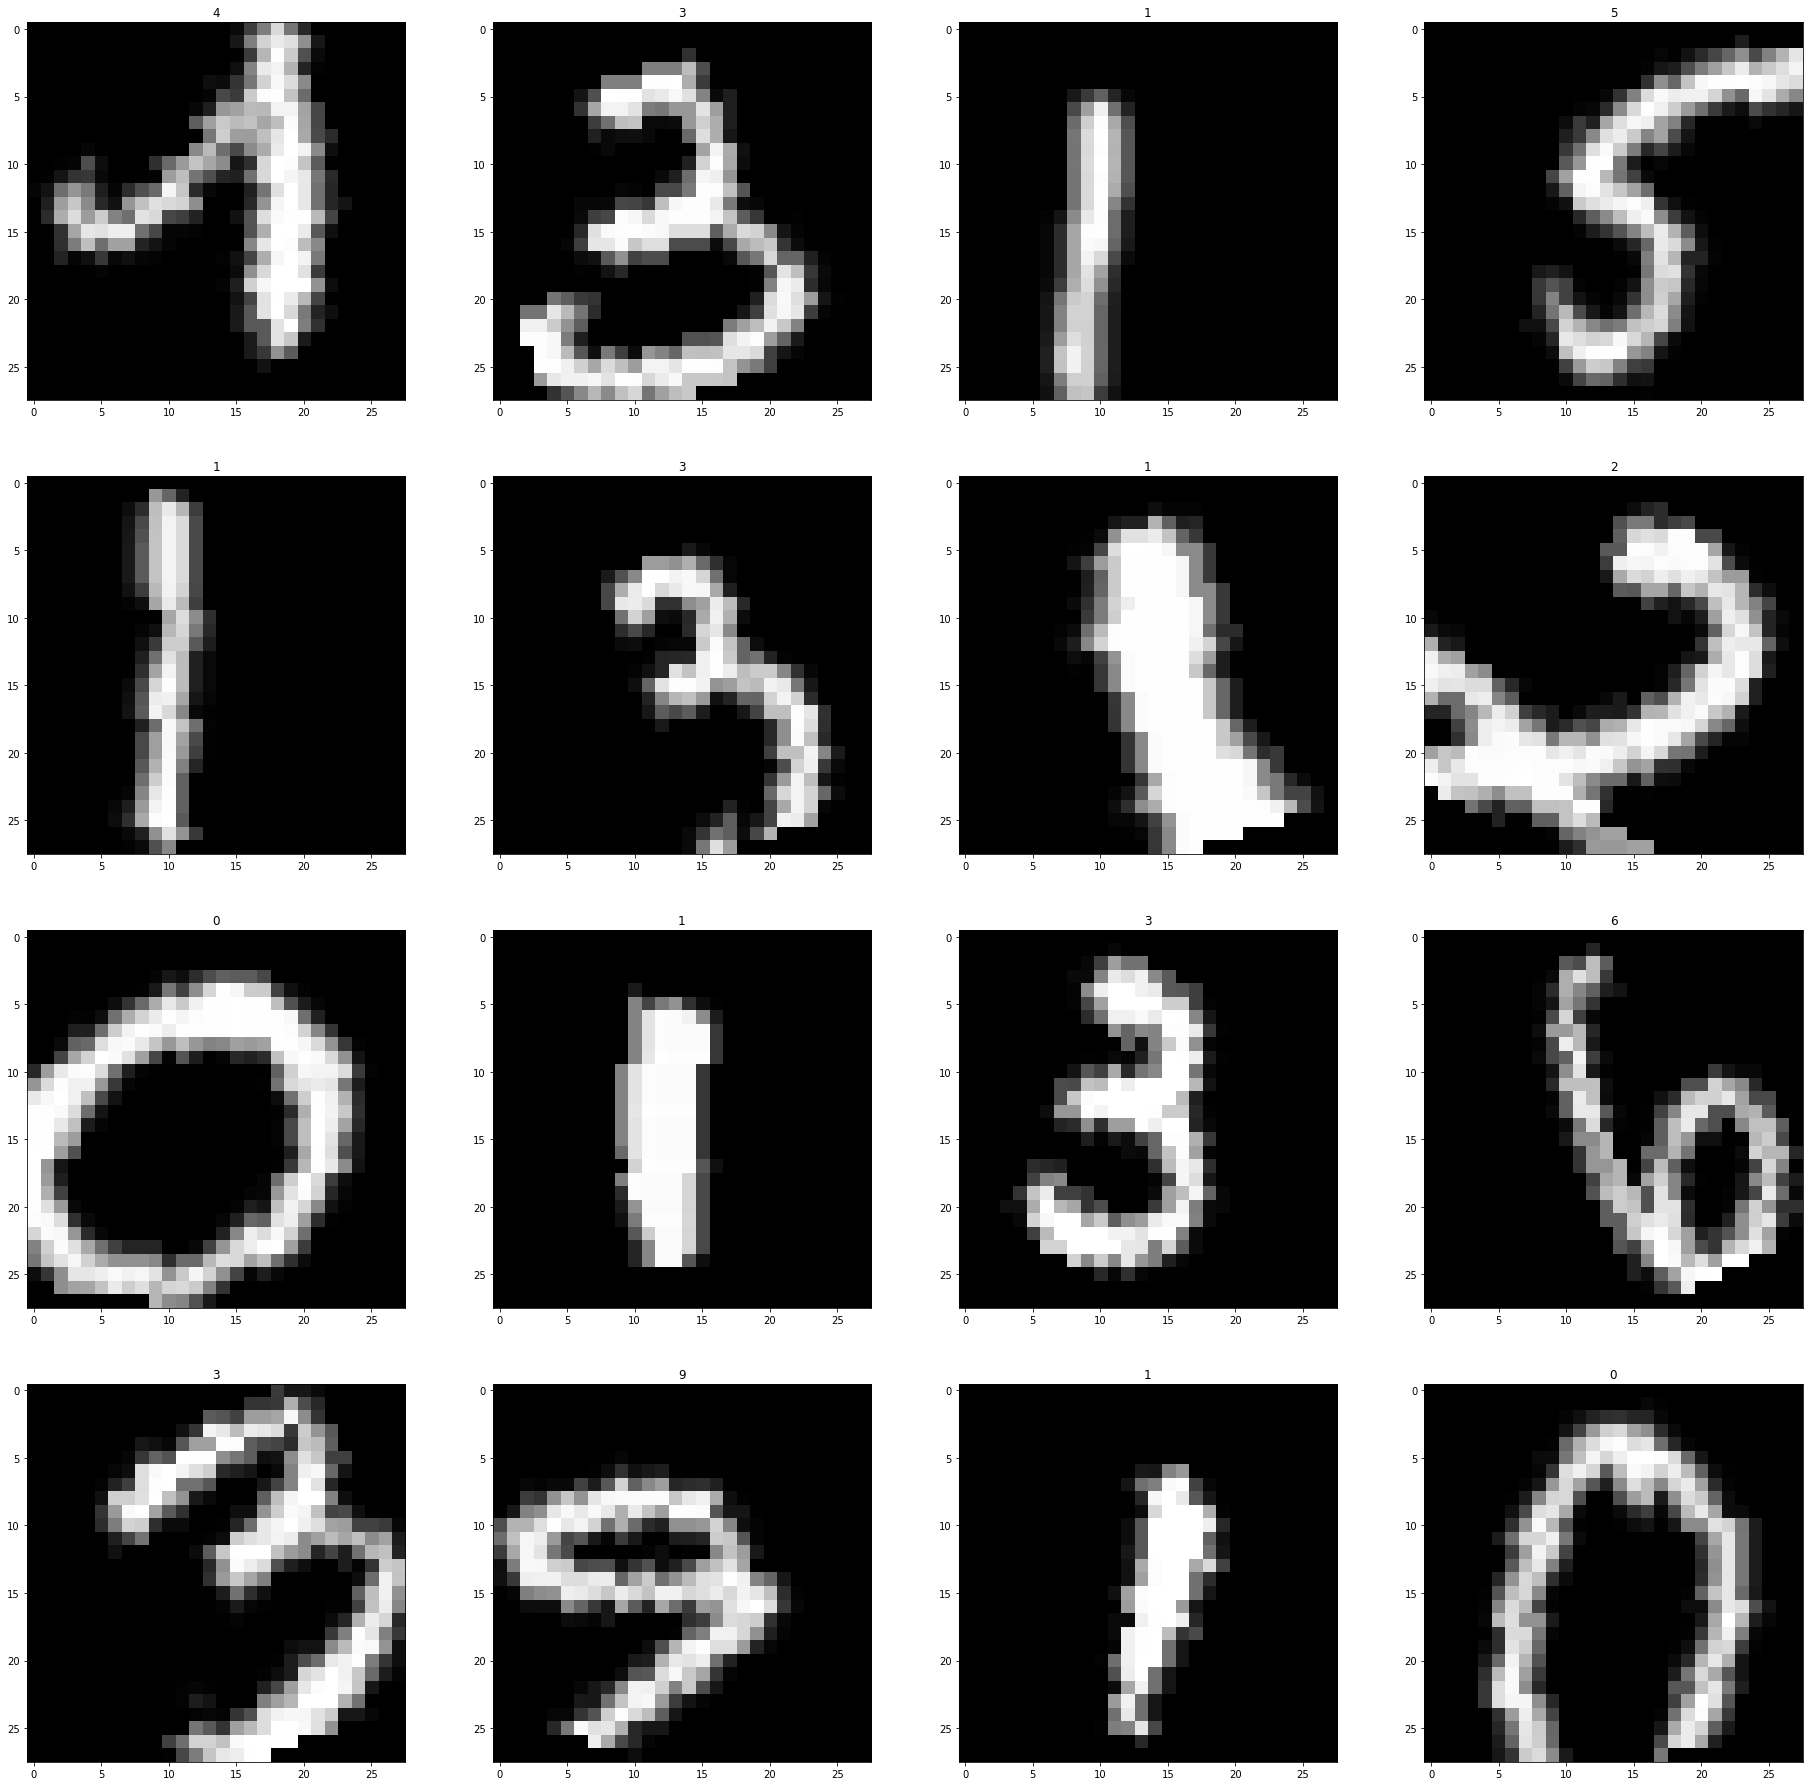

In [23]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*4+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(np.squeeze(sample.cpu().numpy().transpose(1, 2, 0)), cmap='gray')
        ax.set_title(label)

In [11]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 10):
    
    #region TENSORBOARD tutorial
    tb_writer = SummaryWriter(log_dir='./TBoard/run001/')
    #endregion ##############################
    
    #region borrowed from HW03
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    loss_history = []
    #endregion borrowed from HW03
    
    for epoch in range(max_epochs):
        #region borrowed from HW03
        print(f'Epoch {epoch}')
        train_epoch_loss_history = train_single_epoch(model, optimizer, loss_function, train_loader, tb_writer, epoch)
        loss_history = loss_history+train_epoch_loss_history
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        #endregion ##############################
        
        #region TENSORBOARD tutorial
        tb_writer.add_scalar('train_loss', np.sum(train_epoch_loss_history)/len(train_loader.dataset), global_step=epoch)
        tb_writer.add_scalar('val_loss', val_metrics['loss'], global_step=epoch)
        tb_writer.add_scalar('val_accuracy', val_metrics['accuracy'], global_step=epoch)
        #endregion ##############################
        
        #region borrowed from HW03
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return
        #endregion ##############################

In [14]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001,
            max_epochs=100)

Epoch 0


100%|██████████| 157/157 [00:02<00:00, 76.77it/s]
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:389: UserWarning: Couldn't retrieve source code for container of type Perceptron. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation metrics: 
{'loss': 0.005503130340576172, 'accuracy': 0.903}
Best model yet, saving
Epoch 1


100%|██████████| 157/157 [00:01<00:00, 78.69it/s]


Validation metrics: 
{'loss': 0.003576213455200195, 'accuracy': 0.9365}
Best model yet, saving
Epoch 2


100%|██████████| 157/157 [00:01<00:00, 78.68it/s]


Validation metrics: 
{'loss': 0.002897256278991699, 'accuracy': 0.9459}
Best model yet, saving
Epoch 3


100%|██████████| 157/157 [00:01<00:00, 78.61it/s]


Validation metrics: 
{'loss': 0.0024596723556518556, 'accuracy': 0.9541}
Best model yet, saving
Epoch 4


100%|██████████| 157/157 [00:02<00:00, 78.40it/s]


Validation metrics: 
{'loss': 0.0021805875778198244, 'accuracy': 0.9587}
Best model yet, saving
Epoch 5


100%|██████████| 157/157 [00:01<00:00, 80.17it/s]


Validation metrics: 
{'loss': 0.0018417430877685546, 'accuracy': 0.9654}
Best model yet, saving
Epoch 6


100%|██████████| 157/157 [00:02<00:00, 76.81it/s]


Validation metrics: 
{'loss': 0.001617580223083496, 'accuracy': 0.9677}
Best model yet, saving
Epoch 7


100%|██████████| 157/157 [00:01<00:00, 80.15it/s]


Validation metrics: 
{'loss': 0.001585945701599121, 'accuracy': 0.9701}
Best model yet, saving
Epoch 8


100%|██████████| 157/157 [00:02<00:00, 77.33it/s]


Validation metrics: 
{'loss': 0.0013769684791564941, 'accuracy': 0.9733}
Best model yet, saving
Epoch 9


100%|██████████| 157/157 [00:02<00:00, 78.12it/s]


Validation metrics: 
{'loss': 0.001337901020050049, 'accuracy': 0.9736}
Best model yet, saving
Epoch 10


100%|██████████| 157/157 [00:01<00:00, 78.78it/s]


Validation metrics: 
{'loss': 0.0014603645324707032, 'accuracy': 0.972}
Epoch 11


100%|██████████| 157/157 [00:01<00:00, 80.01it/s]


Validation metrics: 
{'loss': 0.0013930006027221679, 'accuracy': 0.9716}
Epoch 12


100%|██████████| 157/157 [00:01<00:00, 80.10it/s]


Validation metrics: 
{'loss': 0.001416591262817383, 'accuracy': 0.9724}
Epoch 13


100%|██████████| 157/157 [00:01<00:00, 78.59it/s]


Validation metrics: 
{'loss': 0.0011292720794677735, 'accuracy': 0.976}
Best model yet, saving
Epoch 14


100%|██████████| 157/157 [00:01<00:00, 80.38it/s]


Validation metrics: 
{'loss': 0.0011479236602783202, 'accuracy': 0.9767}
Epoch 15


100%|██████████| 157/157 [00:02<00:00, 76.59it/s]


Validation metrics: 
{'loss': 0.0009783435821533203, 'accuracy': 0.9793}
Best model yet, saving
Epoch 16


100%|██████████| 157/157 [00:01<00:00, 79.79it/s]


Validation metrics: 
{'loss': 0.0009375358581542968, 'accuracy': 0.9806}
Best model yet, saving
Epoch 17


100%|██████████| 157/157 [00:01<00:00, 79.92it/s]


Validation metrics: 
{'loss': 0.0009477157592773437, 'accuracy': 0.981}
Epoch 18


100%|██████████| 157/157 [00:02<00:00, 77.33it/s]


Validation metrics: 
{'loss': 0.0009624317169189454, 'accuracy': 0.9821}
Epoch 19


100%|██████████| 157/157 [00:02<00:00, 76.91it/s]


Validation metrics: 
{'loss': 0.0011227292060852052, 'accuracy': 0.9784}
Epoch 20


100%|██████████| 157/157 [00:02<00:00, 78.08it/s]


Validation metrics: 
{'loss': 0.0009481816291809082, 'accuracy': 0.9812}
Epoch 21


100%|██████████| 157/157 [00:01<00:00, 80.67it/s]


Validation metrics: 
{'loss': 0.0009503472328186035, 'accuracy': 0.9798}
Epoch 22


100%|██████████| 157/157 [00:01<00:00, 80.73it/s]


Validation metrics: 
{'loss': 0.0009762796401977539, 'accuracy': 0.9791}
Epoch 23


100%|██████████| 157/157 [00:01<00:00, 80.78it/s]


Validation metrics: 
{'loss': 0.0008917961120605469, 'accuracy': 0.9829}
Best model yet, saving
Epoch 24


100%|██████████| 157/157 [00:02<00:00, 74.96it/s]


Validation metrics: 
{'loss': 0.0010519221305847167, 'accuracy': 0.9781}
Epoch 25


100%|██████████| 157/157 [00:02<00:00, 76.75it/s]


Validation metrics: 
{'loss': 0.0008001436233520508, 'accuracy': 0.9831}
Best model yet, saving
Epoch 26


100%|██████████| 157/157 [00:02<00:00, 76.74it/s]


Validation metrics: 
{'loss': 0.0011241758346557617, 'accuracy': 0.9774}
Epoch 27


100%|██████████| 157/157 [00:02<00:00, 74.03it/s]


Validation metrics: 
{'loss': 0.0008062206268310547, 'accuracy': 0.9839}
Epoch 28


100%|██████████| 157/157 [00:02<00:00, 76.42it/s]


Validation metrics: 
{'loss': 0.0009338441848754883, 'accuracy': 0.982}
Epoch 29


100%|██████████| 157/157 [00:02<00:00, 77.11it/s]


Validation metrics: 
{'loss': 0.0007930821895599365, 'accuracy': 0.9838}
Best model yet, saving
Epoch 30


100%|██████████| 157/157 [00:02<00:00, 76.56it/s]


Validation metrics: 
{'loss': 0.0009051266670227051, 'accuracy': 0.9814}
Epoch 31


100%|██████████| 157/157 [00:02<00:00, 76.55it/s]


Validation metrics: 
{'loss': 0.0007939065456390381, 'accuracy': 0.9831}
Epoch 32


100%|██████████| 157/157 [00:02<00:00, 77.00it/s]


Validation metrics: 
{'loss': 0.0008430281639099121, 'accuracy': 0.9816}
Epoch 33


100%|██████████| 157/157 [00:02<00:00, 76.69it/s]


Validation metrics: 
{'loss': 0.0008815907478332519, 'accuracy': 0.9831}
Epoch 34


100%|██████████| 157/157 [00:02<00:00, 77.42it/s]


Validation metrics: 
{'loss': 0.0009234577178955078, 'accuracy': 0.9819}
Epoch 35


100%|██████████| 157/157 [00:02<00:00, 78.30it/s]


Validation metrics: 
{'loss': 0.0008090731620788574, 'accuracy': 0.9847}
Epoch 36


100%|██████████| 157/157 [00:02<00:00, 77.91it/s]


Validation metrics: 
{'loss': 0.0008386039733886719, 'accuracy': 0.9826}
Epoch 37


100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


Validation metrics: 
{'loss': 0.0007243157386779785, 'accuracy': 0.9852}
Best model yet, saving
Epoch 38


100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


Validation metrics: 
{'loss': 0.0008260533332824707, 'accuracy': 0.9827}
Epoch 39


100%|██████████| 157/157 [00:02<00:00, 78.06it/s]


Validation metrics: 
{'loss': 0.0008579139709472656, 'accuracy': 0.9824}
Epoch 40


100%|██████████| 157/157 [00:02<00:00, 78.18it/s]


Validation metrics: 
{'loss': 0.0008249366760253906, 'accuracy': 0.9819}
Epoch 41


100%|██████████| 157/157 [00:02<00:00, 78.15it/s]


Validation metrics: 
{'loss': 0.0007365270614624024, 'accuracy': 0.9852}
Epoch 42


100%|██████████| 157/157 [00:02<00:00, 78.06it/s]


Validation metrics: 
{'loss': 0.0007859675884246826, 'accuracy': 0.9831}
Epoch 43


100%|██████████| 157/157 [00:02<00:00, 77.91it/s]


Validation metrics: 
{'loss': 0.0007497409343719482, 'accuracy': 0.9839}
Epoch 44


100%|██████████| 157/157 [00:02<00:00, 77.98it/s]


Validation metrics: 
{'loss': 0.0007615347385406494, 'accuracy': 0.9832}
Epoch 45


100%|██████████| 157/157 [00:02<00:00, 77.89it/s]


Validation metrics: 
{'loss': 0.0007182723045349121, 'accuracy': 0.9844}
Best model yet, saving
Epoch 46


100%|██████████| 157/157 [00:02<00:00, 76.04it/s]


Validation metrics: 
{'loss': 0.0006547460556030274, 'accuracy': 0.9871}
Best model yet, saving
Epoch 47


100%|██████████| 157/157 [00:02<00:00, 77.50it/s]


Validation metrics: 
{'loss': 0.0007865253925323486, 'accuracy': 0.9848}
Epoch 48


100%|██████████| 157/157 [00:02<00:00, 77.73it/s]


Validation metrics: 
{'loss': 0.0007065803050994873, 'accuracy': 0.9854}
Epoch 49


100%|██████████| 157/157 [00:02<00:00, 77.25it/s]


Validation metrics: 
{'loss': 0.0007204115867614746, 'accuracy': 0.9852}
Epoch 50


100%|██████████| 157/157 [00:02<00:00, 77.41it/s]


Validation metrics: 
{'loss': 0.0006755746841430664, 'accuracy': 0.986}
Epoch 51


100%|██████████| 157/157 [00:01<00:00, 79.77it/s]


Validation metrics: 
{'loss': 0.0007190845489501953, 'accuracy': 0.9853}
Epoch 52


100%|██████████| 157/157 [00:01<00:00, 80.16it/s]


Validation metrics: 
{'loss': 0.0007830438137054444, 'accuracy': 0.9841}
Epoch 53


100%|██████████| 157/157 [00:01<00:00, 79.09it/s]


Validation metrics: 
{'loss': 0.0007011369705200195, 'accuracy': 0.9854}
Epoch 54


100%|██████████| 157/157 [00:01<00:00, 79.03it/s]


Validation metrics: 
{'loss': 0.0007528419494628907, 'accuracy': 0.9839}
Epoch 55


100%|██████████| 157/157 [00:02<00:00, 78.44it/s]


Validation metrics: 
{'loss': 0.0006341274738311767, 'accuracy': 0.9867}
Best model yet, saving
Epoch 56


100%|██████████| 157/157 [00:02<00:00, 77.84it/s]


Validation metrics: 
{'loss': 0.0006561901092529297, 'accuracy': 0.986}
Epoch 57


100%|██████████| 157/157 [00:02<00:00, 76.85it/s]


Validation metrics: 
{'loss': 0.000704694938659668, 'accuracy': 0.9859}
Epoch 58


100%|██████████| 157/157 [00:02<00:00, 78.37it/s]


Validation metrics: 
{'loss': 0.0006757801532745361, 'accuracy': 0.9862}
Epoch 59


100%|██████████| 157/157 [00:01<00:00, 78.50it/s]


Validation metrics: 
{'loss': 0.0006370189189910889, 'accuracy': 0.9879}
Epoch 60


100%|██████████| 157/157 [00:01<00:00, 79.61it/s]


Validation metrics: 
{'loss': 0.0007466973781585693, 'accuracy': 0.9848}
Epoch 61


100%|██████████| 157/157 [00:01<00:00, 79.55it/s]


Validation metrics: 
{'loss': 0.0006283527374267578, 'accuracy': 0.9871}
Best model yet, saving
Epoch 62


100%|██████████| 157/157 [00:01<00:00, 79.88it/s]


Validation metrics: 
{'loss': 0.0007238157272338868, 'accuracy': 0.9853}
Epoch 63


100%|██████████| 157/157 [00:01<00:00, 79.09it/s]


Validation metrics: 
{'loss': 0.0007313837051391601, 'accuracy': 0.9851}
Epoch 64


100%|██████████| 157/157 [00:02<00:00, 76.77it/s]


Validation metrics: 
{'loss': 0.0006593853950500488, 'accuracy': 0.9859}
Epoch 65


100%|██████████| 157/157 [00:02<00:00, 78.00it/s]


Validation metrics: 
{'loss': 0.0006278841018676757, 'accuracy': 0.9863}
Best model yet, saving
Epoch 66


100%|██████████| 157/157 [00:01<00:00, 79.98it/s]


Validation metrics: 
{'loss': 0.0006067938327789307, 'accuracy': 0.9867}
Best model yet, saving
Epoch 67


100%|██████████| 157/157 [00:01<00:00, 79.14it/s]


Validation metrics: 
{'loss': 0.0006868948936462402, 'accuracy': 0.9852}
Epoch 68


100%|██████████| 157/157 [00:01<00:00, 79.58it/s]


Validation metrics: 
{'loss': 0.0006788438320159912, 'accuracy': 0.986}
Epoch 69


100%|██████████| 157/157 [00:01<00:00, 79.93it/s]


Validation metrics: 
{'loss': 0.0006484218597412109, 'accuracy': 0.9861}
Epoch 70


100%|██████████| 157/157 [00:01<00:00, 79.72it/s]


Validation metrics: 
{'loss': 0.0005955554962158203, 'accuracy': 0.9876}
Best model yet, saving
Epoch 71


100%|██████████| 157/157 [00:01<00:00, 80.52it/s]


Validation metrics: 
{'loss': 0.0006690867900848389, 'accuracy': 0.9863}
Epoch 72


100%|██████████| 157/157 [00:01<00:00, 78.90it/s]


Validation metrics: 
{'loss': 0.0005614675998687744, 'accuracy': 0.9875}
Best model yet, saving
Epoch 73


100%|██████████| 157/157 [00:01<00:00, 79.72it/s]


Validation metrics: 
{'loss': 0.0005781841278076172, 'accuracy': 0.988}
Epoch 74


100%|██████████| 157/157 [00:02<00:00, 77.24it/s]


Validation metrics: 
{'loss': 0.0007017138957977295, 'accuracy': 0.9856}
Epoch 75


100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


Validation metrics: 
{'loss': 0.000587958574295044, 'accuracy': 0.9869}
Epoch 76


100%|██████████| 157/157 [00:02<00:00, 77.89it/s]


Validation metrics: 
{'loss': 0.0005588385581970215, 'accuracy': 0.9887}
Best model yet, saving
Epoch 77


100%|██████████| 157/157 [00:02<00:00, 77.77it/s]


Validation metrics: 
{'loss': 0.000654732608795166, 'accuracy': 0.9853}
Epoch 78


100%|██████████| 157/157 [00:02<00:00, 77.81it/s]


Validation metrics: 
{'loss': 0.0006333005905151367, 'accuracy': 0.9871}
Epoch 79


100%|██████████| 157/157 [00:02<00:00, 76.50it/s]


Validation metrics: 
{'loss': 0.0005343877792358398, 'accuracy': 0.9891}
Best model yet, saving
Epoch 80


100%|██████████| 157/157 [00:02<00:00, 77.84it/s]


Validation metrics: 
{'loss': 0.0006238835334777832, 'accuracy': 0.9859}
Epoch 81


100%|██████████| 157/157 [00:02<00:00, 76.24it/s]


Validation metrics: 
{'loss': 0.0005752913475036621, 'accuracy': 0.988}
Epoch 82


100%|██████████| 157/157 [00:02<00:00, 78.46it/s]


Validation metrics: 
{'loss': 0.000611608362197876, 'accuracy': 0.9871}
Epoch 83


100%|██████████| 157/157 [00:01<00:00, 78.58it/s]


Validation metrics: 
{'loss': 0.0006283111572265625, 'accuracy': 0.9865}
Epoch 84


100%|██████████| 157/157 [00:01<00:00, 80.64it/s]


Validation metrics: 
{'loss': 0.0006382704734802246, 'accuracy': 0.9865}
Epoch 85


100%|██████████| 157/157 [00:01<00:00, 80.69it/s]


Validation metrics: 
{'loss': 0.0006196152210235596, 'accuracy': 0.9868}
Epoch 86


100%|██████████| 157/157 [00:01<00:00, 80.62it/s]


Validation metrics: 
{'loss': 0.000674467945098877, 'accuracy': 0.9866}
Epoch 87


100%|██████████| 157/157 [00:01<00:00, 80.23it/s]


Validation metrics: 
{'loss': 0.00062064528465271, 'accuracy': 0.9862}
Epoch 88


100%|██████████| 157/157 [00:01<00:00, 79.49it/s]


Validation metrics: 
{'loss': 0.0005760268688201905, 'accuracy': 0.9869}
Epoch 89


100%|██████████| 157/157 [00:01<00:00, 78.54it/s]


Validation metrics: 
{'loss': 0.0005472909927368164, 'accuracy': 0.9879}
Epoch 90


100%|██████████| 157/157 [00:02<00:00, 76.46it/s]

Validation metrics: 
{'loss': 0.0005381316661834716, 'accuracy': 0.9882}
Early stopping triggered
